In [52]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np


PredictorScaler=StandardScaler()
TargetVarScaler=StandardScaler()

def data_standard(X, y, PredictorScaler, TargetVarScaler):
    PredictorScalerFit=PredictorScaler.fit(X)
    TargetVarScalerFit=TargetVarScaler.fit(y)
    X=PredictorScalerFit.transform(X)
    y=TargetVarScalerFit.transform(y)
    return X, y, PredictorScalerFit, TargetVarScalerFit

    

In [3]:
import tensorflow as tf
import tensorflow_addons as tfa

C:\Users\annac\anaconda\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
#CNN Model Descition
from keras.models import Sequential
from keras.layers import Dense, Dropout
#from keras.metrics import mean_squared_error


def findBestANNParams(X_train, y_train, X_test, y_test, dim):
    
    # Defining the list of hyper parameters to try
    batch_size_list=[5, 10, 15, 20]
    epoch_list  =   [5, 10, 50, 100]
    
    SearchResultsData=pd.DataFrame(columns=['TrialNumber', 'Parameters', 'MSE'])
    
    # initializing the trials
    TrialNumber=0
    for batch_size_trial in batch_size_list:
        for epochs_trial in epoch_list:
            TrialNumber+=1
            # create ANN model
            model = Sequential()
 
            # Defining the Input layer and FIRST hidden layer, both are same!
            model.add(Dense(units=8, input_dim=dim, kernel_initializer='normal', activation='relu'))

            model.add(Dropout(0.2))
 
            # Defining the Second layer of the model
            # after the first layer we don't have to specify input_dim as keras configure it automatically
            model.add(Dense(units=32, kernel_initializer='normal', activation='relu'))

            model.add(Dropout(0.2))

            model.add(Dense(units=16, kernel_initializer='normal', activation='relu'))
    
 
            # The output neuron is a single fully connected node 
            # Since we will be predicting a single number
            model.add(Dense(1, kernel_initializer='normal', activation='linear'))
 
            # Compiling the model
            model.compile(loss='mean_squared_error', optimizer='adam')
            # Fitting the ANN to the Training set
            model.fit(X_train, y_train ,batch_size = batch_size_trial, epochs = epochs_trial, verbose=0)
 
            #MAPE = np.mean(100 * (np.abs(y_test-model.predict(X_test))/y_test))
            y_pred = model.predict(X_test)
            MSE = np.mean(np.square(y_test - y_pred))
    
            
            # printing the results of the current iteration
            #print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', 100-MAPE)
            
            SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],
                                                                    columns=['TrialNumber', 'Batch', 'Epochs', 'MSE'] ))
            
    print(SearchResultsData)
            
    return(SearchResultsData)

In [5]:
from sklearn.metrics import mean_squared_error, accuracy_score

from tensorflow.keras.metrics import MeanSquaredError

def get_scores(model, model_type, TargetVarScalerFit, PredictorScalerFit, X_test, y_test):
    predictions=model.predict(X_test)
    
    score = 0
    mse = 0
    if(model_type == 's'):
        metric = tfa.metrics.r_square.RSquare()
        metric.update_state(y_test, predictions)
        r = metric.result()
        score = r.numpy()
        
        metric_mse = MeanSquaredError()
        metric_mse.update_state(y_test, predictions)
        mse = metric_mse.result().numpy()
        #acc = accuracy_score(y_test, predictions, normalize = True)
    else:
        mse = mean_squared_error(y_test, predictions)
        score = model.score(X_test,y_test)
        #acc = accuracy_score(y_test, predictions, normalize = True)
    predictions=TargetVarScalerFit.inverse_transform(predictions)
    y_test_orig=TargetVarScalerFit.inverse_transform(y_test)
    Test_Data=PredictorScalerFit.inverse_transform(X_test)
    TestingData=pd.DataFrame(data=y_test_orig, columns=['ActualValue'])
    TestingData['Predicted']=predictions
    TestingData['Diff']=TestingData['ActualValue']-TestingData['Predicted']
    TestingData['Diff'] = TestingData['Diff'].abs()
    APE=100*TestingData['Diff']/TestingData['ActualValue']
    
    scores = pd.DataFrame()
    
    print("R-squared:", score)
   
    #acc = 100-np.mean(APE)
    print("MSE:", mse)
    #print('The Accuracy of the following model is:', acc)
    
    #sc_arr = [score, mse, acc]
    sc_pd = pd.DataFrame({'R^2': [score], 'MSE': [mse]})
    
    return sc_pd, TestingData
    
    
    
    

In [24]:
targets = pd.read_csv('C:/Users/annac/avr_hosp_data.csv')

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
def ANN_model(targets,target_name, file_name):
    df_pd = pd.read_csv(file_name+'.csv') #target_name
    X=df_pd.values
    y = targets[[target_name]].values
    dim = len(df_pd.columns)
    
    X, y, PredictorScalerFit, TargetVarScalerFit = data_standard(X, y, PredictorScaler, TargetVarScaler)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    ResultsData=findBestANNParams(X_train, y_train, X_test, y_test, dim)
    
    mses = list(ResultsData['MSE'])
    index_m = 0
    
    for i in range(0, len(mses)):
        if mses[i] < mses[index_m]:
            index_m = i
    
    
    #index_acc = acc_l.index(max_a)
    print("index_m:"+str(index_m))
    
    epochs = ResultsData.iloc[index_m]['Epochs']
    
    epochs = int(epochs)
    
    batch = ResultsData.iloc[index_m]['Batch']
    
    batch = int(batch)
    
    
    
   # print(ResultsData)
    
    
    model = Sequential()
 

    model.add(Dense(units=8, input_dim=dim, kernel_initializer='normal', activation='relu'))

    model.add(Dropout(0.2))
 
    model.add(Dense(units=32, kernel_initializer='normal', activation='relu'))

    model.add(Dropout(0.2))

    model.add(Dense(units=16, kernel_initializer='normal', activation='relu'))
    
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))

    model.compile(loss='mean_squared_error', optimizer='adam')
    
    model.fit(X_train, y_train ,batch_size = batch, epochs = epochs, verbose=1)
    
    
    scores, predictions = get_scores(model, 's', TargetVarScalerFit, PredictorScalerFit, X_test, y_test)
    
    print(predictions.head(50))
    print(scores)
    
    return scores, predictions
    
    
    
    
    

In [8]:
from sklearn.svm import SVR

def SVM_model(targets,target_name, file_name):
    df_pd = pd.read_csv(file_name+'.csv') #target_name
    X=df_pd.values
    y = targets[[target_name]].values
    
    X, y, PredictorScalerFit, TargetVarScalerFit = data_standard(X, y, PredictorScaler, TargetVarScaler)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = SVR(kernel = 'rbf')
    model.fit(X_train, y_train)
    scores, predictions = get_scores(model, 'ml', TargetVarScalerFit, PredictorScalerFit, X_test, y_test)
    
    return scores, predictions
    

In [9]:
from sklearn.neighbors import KNeighborsRegressor

def KNN_model(targets,target_name, file_name):
    df_pd = pd.read_csv(file_name+'.csv') #target_name
    X=df_pd.values
    y = targets[[target_name]].values
    
    X, y, PredictorScalerFit, TargetVarScalerFit = data_standard(X, y, PredictorScaler, TargetVarScaler)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    mses = []

    for k in range(2, 11):

        model = KNeighborsRegressor(n_neighbors=k)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        

        #score = model.score(X_test, y_test)
       
        MSE = mean_squared_error(y_test, y_pred)
        print("K=%d, val_mse=%.2f%%" % (k, MSE))
        mses.append(MSE)
        
    index_m = 0

    for i in range(0, len(mses)):
        if mses[i] < mses[index_m]:
            index_m = i
    
    #min_mse = min(mses)
    
    #print(min_mse)
    
    
    #index_m = mses.index(min_mse)
    print("index_mse:"+str(index_m))
        
    model = KNeighborsRegressor(n_neighbors=index_m+2)
    model.fit(X_train, y_train)
    
    scores, predictions = get_scores(model, 'ml', TargetVarScalerFit, PredictorScalerFit, X_test, y_test)
    
    return scores, predictions


In [10]:
from sklearn.linear_model import LinearRegression
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
def LR_model(targets,target_name, file_name):
    df_pd = pd.read_csv(file_name+'.csv') #target_name
    X=df_pd.values
    y = targets[[target_name]].values
    
    X, y, PredictorScalerFit, TargetVarScalerFit = data_standard(X, y, PredictorScaler, TargetVarScaler)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    reg = model.fit(X_train, y_train)
    print(reg.score(X_train, y_train))
    print(reg.intercept_)
    scores, predictions = get_scores(model, 'ml', TargetVarScalerFit, PredictorScalerFit, X_test, y_test)
    
    return scores, predictions
    

In [121]:
scores_ANN, pred_ANN = ANN_model(targets,'Daily hospital occupancy', 'avr_Daily_hospital_occupancy')

2/2 [==============================] - 1s 256ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 115ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 55ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 4ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step
  TrialNumber Parameters       MSE  Batch  Epochs
0           1        NaN  0.214579    5.0     5.0
0           2        NaN  0.173281    5.0    10.0
0           3        NaN  0.127805    5.0    50.0
0           4        NaN  0.148269    5.0   100.0
0           5        NaN  0.374397   10.0     5.0
0           6        NaN  0.189859   10.0    10.0
0           7        NaN  0.145021   10.0    50.0
0           8        NaN  0.140420   10.0   100.0
0           9        NaN  0.691336   15.0     5.0
0          10        NaN  0.236065   15.0    10.0
0          11        NaN  0.162831   15.0    50.0
0          12        NaN  0.124696   15.0   100.0
0          13        NaN  0.886194   20.0     5.0
0          14        NaN  0.467219   20.0    10.0
0          15        NaN  0.148765   20.0    50.0
0          16        NaN  0.142185   20.0   100.0
index_m:11
Epoch 1/100


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


11/11 [==============================] - 0s 2ms/step - loss: 0.9677
Epoch 2/100
11/11 [==============================] - 0s 2ms/step - loss: 0.9637
Epoch 3/100
11/11 [==============================] - 0s 1ms/step - loss: 0.9495
Epoch 4/100
11/11 [==============================] - 0s 2ms/step - loss: 0.9089
Epoch 5/100
11/11 [==============================] - 0s 2ms/step - loss: 0.7893
Epoch 6/100
11/11 [==============================] - 0s 2ms/step - loss: 0.5788
Epoch 7/100
11/11 [==============================] - 0s 2ms/step - loss: 0.4262
Epoch 8/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3407
Epoch 9/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3540
Epoch 10/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2979
Epoch 11/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3526
Epoch 12/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3505
Epoch 13/100
11/11 [=============================

In [132]:
ANN_model(targets,'Daily hospital occupancy', 'avr_Daily_hospital_occupancy')

2/2 [==============================] - 1s 99ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 8ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 4ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 4ms/step
  TrialNumber Parameters       MSE  Batch  Epochs
0           1        NaN  0.204605    5.0     5.0
0           2        NaN  0.166586    5.0    10.0
0           3        NaN  0.109987    5.0    50.0
0           4        NaN  0.138601    5.0   100.0
0           5        NaN  0.553746   10.0     5.0
0           6        NaN  0.200868   10.0    10.0
0           7        NaN  0.134876   10.0    50.0
0           8        NaN  0.135752   10.0   100.0
0           9        NaN  0.874699   15.0     5.0
0          10        NaN  0.205723   15.0    10.0
0          11        NaN  0.128917   15.0    50.0
0          12        NaN  0.132713   15.0   100.0
0          13        NaN  0.818151   20.0     5.0
0          14        NaN  0.550420   20.0    10.0
0          15        NaN  0.150285   20.0    50.0
0          16        NaN  0.127900   20.0   100.0
index_m:2
Epoch 1/50


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


33/33 [==============================] - 1s 1ms/step - loss: 0.9670
Epoch 2/50
33/33 [==============================] - 0s 1ms/step - loss: 0.9320
Epoch 3/50
33/33 [==============================] - 0s 1ms/step - loss: 0.6570
Epoch 4/50
33/33 [==============================] - 0s 2ms/step - loss: 0.3828
Epoch 5/50
33/33 [==============================] - 0s 2ms/step - loss: 0.3416
Epoch 6/50
33/33 [==============================] - 0s 2ms/step - loss: 0.3669
Epoch 7/50
33/33 [==============================] - 0s 2ms/step - loss: 0.3780
Epoch 8/50
33/33 [==============================] - 0s 2ms/step - loss: 0.3177
Epoch 9/50
33/33 [==============================] - 0s 2ms/step - loss: 0.3107
Epoch 10/50
33/33 [==============================] - 0s 2ms/step - loss: 0.2355
Epoch 11/50
33/33 [==============================] - 0s 2ms/step - loss: 0.2755
Epoch 12/50
33/33 [==============================] - 0s 2ms/step - loss: 0.3026
Epoch 13/50
33/33 [==============================] - 0s 2ms/

(        R^2       MSE
 0  0.859418  0.156316,
     ActualValue    Predicted         Diff
 0   4153.500000  3553.663086   599.836914
 1   3952.400000  3428.925293   523.474707
 2    943.076923  1095.281372   152.204449
 3   2945.370370  2312.398682   632.971689
 4   1464.148148  1236.161865   227.986283
 5    932.038462   798.931091   133.107370
 6   1989.379310  2302.583008   313.203697
 7   1969.655172  2296.594238   326.939066
 8   2280.000000  2246.602783    33.397217
 9   1980.689655  2315.367920   334.678265
 10  2251.178571  2288.830078    37.651507
 11  1942.375000  2285.955811   343.580811
 12  1626.777778  1614.416138    12.361640
 13  1932.586207  2303.055664   370.469457
 14  1468.000000  1411.133179    56.866821
 15  2110.758621  2260.152832   149.394211
 16  4251.291667  3570.654053   680.637614
 17  1069.370370  1117.369263    47.998892
 18  1018.037037  1122.211548   104.174511
 19  2359.093750  2303.972900    55.120850
 20  1796.142857  2271.218506   475.075649
 21   9

In [120]:
scores_SVM, pred_SVM = SVM_model(targets,'Daily hospital occupancy', 'avr_Daily_hospital_occupancy')

R-squared: 0.8832559246655615
MSE: 0.1298105363987145


C:\Users\annac\anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [83]:
SVM_model(targets,'Daily hospital occupancy', 'avr_Daily_hospital_occupancy')

R-squared: 0.8832559246655615
MSE: 0.1298105363987145


C:\Users\annac\anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,R^2,MSE
0,0.883256,0.129811


In [128]:
scores_KNN, pred_KNN = KNN_model(targets,'Daily hospital occupancy', 'avr_Daily_hospital_occupancy')

K=2, val_mse=0.17%
K=3, val_mse=0.16%
K=4, val_mse=0.15%
K=5, val_mse=0.15%
K=6, val_mse=0.13%
K=7, val_mse=0.13%
K=8, val_mse=0.13%
K=9, val_mse=0.13%
K=10, val_mse=0.14%
index_mse:5
R-squared: 0.8838588989845667
MSE: 0.12914007479661185


In [84]:
KNN_model(targets,'Daily hospital occupancy', 'avr_Daily_hospital_occupancy')

K=2, val_mse=0.17%
K=3, val_mse=0.16%
K=4, val_mse=0.15%
K=5, val_mse=0.15%
K=6, val_mse=0.13%
K=7, val_mse=0.13%
K=8, val_mse=0.13%
K=9, val_mse=0.13%
K=10, val_mse=0.14%
index_mse:5
R-squared: 0.8838588989845667
MSE: 0.12914007479661185


,R^2,MSE
0,0.883859,0.12914


In [130]:
scores_LR, pred_LR = LR_model(targets,'Daily hospital occupancy', 'avr_Daily_hospital_occupancy')

0.8873392424089649
[0.01818173]
R-squared: 0.7952064186572096
MSE: 0.22771489318806754


In [131]:
LR_model(targets,'Daily hospital occupancy', 'avr_Daily_hospital_occupancy')

0.8873392424089649
[0.01818173]
R-squared: 0.7952064186572096
MSE: 0.22771489318806754


(        R^2       MSE
 0  0.795206  0.227715,
     ActualValue    Predicted         Diff
 0   4153.500000  3770.619310   382.880690
 1   3952.400000  3612.725721   339.674279
 2    943.076923  1047.457526   104.380603
 3   2945.370370  2459.880698   485.489673
 4   1464.148148   924.915671   539.232477
 5    932.038462  1380.108650   448.070189
 6   1989.379310  2277.393814   288.014503
 7   1969.655172  2337.695100   368.039927
 8   2280.000000  2032.601954   247.398046
 9   1980.689655  2271.118864   290.429209
 10  2251.178571  2178.731118    72.447454
 11  1942.375000  2094.353300   151.978300
 12  1626.777778  1643.144624    16.366847
 13  1932.586207  2062.599703   130.013496
 14  1468.000000  1371.857542    96.142458
 15  2110.758621  2045.380131    65.378490
 16  4251.291667  4117.400274   133.891392
 17  1069.370370  1171.762460   102.392089
 18  1018.037037  1159.125845   141.088808
 19  2359.093750  3024.592051   665.498301
 20  1796.142857  2252.376388   456.233531
 21   9

In [85]:
targets_USA = pd.read_csv('hosp_data_USA.csv')

In [86]:
usa_filter = targets_USA[['Daily ICU occupancy']].loc[targets_USA['Daily ICU occupancy']>= 0.0]

In [87]:
ANN_model(usa_filter,'Daily ICU occupancy', 'small_usa_data')

1/1 [==============================] - 0s 79ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


1/1 [==============================] - 0s 80ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


1/1 [==============================] - 0s 78ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


1/1 [==============================] - 0s 81ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


1/1 [==============================] - 0s 79ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


1/1 [==============================] - 0s 79ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


1/1 [==============================] - 0s 79ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


1/1 [==============================] - 0s 48ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


1/1 [==============================] - 0s 77ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


1/1 [==============================] - 0s 83ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


1/1 [==============================] - 0s 78ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


1/1 [==============================] - 0s 78ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


1/1 [==============================] - 0s 79ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


1/1 [==============================] - 0s 78ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


1/1 [==============================] - 0s 80ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


1/1 [==============================] - 0s 80ms/step
  TrialNumber Parameters       MSE  Batch  Epochs
0           1        NaN  0.590352    5.0     5.0
0           2        NaN  0.416494    5.0    10.0
0           3        NaN  0.357739    5.0    50.0
0           4        NaN  0.293072    5.0   100.0
0           5        NaN  0.967775   10.0     5.0
0           6        NaN  0.453973   10.0    10.0
0           7        NaN  0.339280   10.0    50.0
0           8        NaN  0.351169   10.0   100.0
0           9        NaN  1.013895   15.0     5.0
0          10        NaN  0.830807   15.0    10.0
0          11        NaN  0.370101   15.0    50.0
0          12        NaN  0.327254   15.0   100.0
0          13        NaN  1.021962   20.0     5.0
0          14        NaN  0.927231   20.0    10.0
0          15        NaN  0.348495   20.0    50.0
0          16        NaN  0.346984   20.0   100.0
index_m:3
Epoch 1/100


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


15/15 [==============================] - 0s 2ms/step - loss: 0.9889
Epoch 2/100
15/15 [==============================] - 0s 2ms/step - loss: 0.9802
Epoch 3/100
15/15 [==============================] - 0s 2ms/step - loss: 0.9496
Epoch 4/100
15/15 [==============================] - 0s 2ms/step - loss: 0.8627
Epoch 5/100
15/15 [==============================] - 0s 2ms/step - loss: 0.6942
Epoch 6/100
15/15 [==============================] - 0s 2ms/step - loss: 0.5014
Epoch 7/100
15/15 [==============================] - 0s 2ms/step - loss: 0.3803
Epoch 8/100
15/15 [==============================] - 0s 2ms/step - loss: 0.3200
Epoch 9/100
15/15 [==============================] - 0s 2ms/step - loss: 0.2418
Epoch 10/100
15/15 [==============================] - 0s 2ms/step - loss: 0.2486
Epoch 11/100
15/15 [==============================] - 0s 2ms/step - loss: 0.2328
Epoch 12/100
15/15 [==============================] - 0s 2ms/step - loss: 0.2216
Epoch 13/100
15/15 [=============================

,R^2,MSE
0,0.650084,0.352145


In [88]:
SVM_model(usa_filter,'Daily ICU occupancy', 'small_usa_data')

R-squared: 0.6928569628387606
MSE: 0.3090997627489058


C:\Users\annac\anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,R^2,MSE
0,0.692857,0.3091


In [89]:
KNN_model(usa_filter,'Daily ICU occupancy', 'small_usa_data')

K=2, val_mse=0.37%
K=3, val_mse=0.35%
K=4, val_mse=0.34%
K=5, val_mse=0.30%
K=6, val_mse=0.33%
K=7, val_mse=0.31%
K=8, val_mse=0.35%
K=9, val_mse=0.34%
K=10, val_mse=0.34%
index_mse:3
R-squared: 0.6988506035907236
MSE: 0.3030679381255745


,R^2,MSE
0,0.698851,0.303068


In [107]:
LR_model(usa_filter,'Daily ICU occupancy', 'small_usa_data')

0.8515215135267227
[0.01091072]
R-squared: 0.6246181142570044
MSE: 0.3777733426608165


,R^2,MSE
0,0.624618,0.377773


In [90]:
targets_Eng = pd.read_csv('hosp_data_Eng.csv')
eng_filter = targets_Eng[['Daily ICU occupancy']].loc[targets_Eng['Daily ICU occupancy']>= 0.0]

In [91]:
ANN_model(eng_filter,'Daily ICU occupancy', 'small_eng_data')

2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 4ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step
  TrialNumber Parameters       MSE  Batch  Epochs
0           1        NaN  0.094304    5.0     5.0
0           2        NaN  0.081076    5.0    10.0
0           3        NaN  0.082912    5.0    50.0
0           4        NaN  0.095514    5.0   100.0
0           5        NaN  0.129350   10.0     5.0
0           6        NaN  0.064545   10.0    10.0
0           7        NaN  0.089847   10.0    50.0
0           8        NaN  0.074304   10.0   100.0
0           9        NaN  0.846437   15.0     5.0
0          10        NaN  0.135449   15.0    10.0
0          11        NaN  0.087616   15.0    50.0
0          12        NaN  0.070274   15.0   100.0
0          13        NaN  1.019457   20.0     5.0
0          14        NaN  0.403600   20.0    10.0
0          15        NaN  0.073666   20.0    50.0
0          16        NaN  0.095212   20.0   100.0
index_m:5
Epoch 1/10


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


16/16 [==============================] - 0s 2ms/step - loss: 0.9442
Epoch 2/10
16/16 [==============================] - 0s 2ms/step - loss: 0.9162
Epoch 3/10
16/16 [==============================] - 0s 2ms/step - loss: 0.8470
Epoch 4/10
16/16 [==============================] - 0s 2ms/step - loss: 0.6091
Epoch 5/10
16/16 [==============================] - 0s 2ms/step - loss: 0.2758
Epoch 6/10
16/16 [==============================] - 0s 2ms/step - loss: 0.0834
Epoch 7/10
16/16 [==============================] - 0s 2ms/step - loss: 0.1038
Epoch 8/10
16/16 [==============================] - 0s 2ms/step - loss: 0.1135
Epoch 9/10
16/16 [==============================] - 0s 2ms/step - loss: 0.0839
Epoch 10/10
2/2 [==============================] - 0s 3ms/step
R-squared: 0.953734
MSE: 0.055295307
    ActualValue    Predicted        Diff
0          64.0   176.164734  112.164734
1        2868.0  2705.579834  162.420166
2          54.0   179.686188  125.686188
3         178.0   258.538940   80.53

,R^2,MSE
0,0.953734,0.055295


In [92]:
SVM_model(eng_filter,'Daily ICU occupancy', 'small_eng_data')

R-squared: 0.936415288652074
MSE: 0.07599393276949498


C:\Users\annac\anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,R^2,MSE
0,0.936415,0.075994


In [108]:
KNN_model(eng_filter,'Daily ICU occupancy', 'small_eng_data')

K=2, val_mse=0.04%
K=3, val_mse=0.03%
K=4, val_mse=0.03%
K=5, val_mse=0.02%
K=6, val_mse=0.03%
K=7, val_mse=0.03%
K=8, val_mse=0.03%
K=9, val_mse=0.03%
K=10, val_mse=0.03%
index_mse:3
R-squared: 0.979725443070786
MSE: 0.024231348755823875


,R^2,MSE
0,0.979725,0.024231


In [109]:
LR_model(eng_filter,'Daily ICU occupancy', 'small_eng_data')

0.9627402589374001
[0.00329063]
R-squared: 0.9433686780769691
MSE: 0.06768351667616426


,R^2,MSE
0,0.943369,0.067684


In [63]:
targets_Ger = pd.read_csv('hosp_data_Ger.csv')
ger_filter = targets_Ger[['Daily ICU occupancy']].loc[targets_Ger['Daily ICU occupancy']>= 0.0]

In [94]:
ANN_model(ger_filter,'Daily ICU occupancy', 'small_ger_data')

2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step
  TrialNumber Parameters       MSE  Batch  Epochs
0           1        NaN  0.054445    5.0     5.0
0           2        NaN  0.054236    5.0    10.0
0           3        NaN  0.057016    5.0    50.0
0           4        NaN  0.041270    5.0   100.0
0           5        NaN  0.065858   10.0     5.0
0           6        NaN  0.069663   10.0    10.0
0           7        NaN  0.053798   10.0    50.0
0           8        NaN  0.056886   10.0   100.0
0           9        NaN  0.547021   15.0     5.0
0          10        NaN  0.063628   15.0    10.0
0          11        NaN  0.047702   15.0    50.0
0          12        NaN  0.049900   15.0   100.0
0          13        NaN  0.375338   20.0     5.0
0          14        NaN  0.098665   20.0    10.0
0          15        NaN  0.050041   20.0    50.0
0          16        NaN  0.083668   20.0   100.0
index_m:3
Epoch 1/100


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


33/33 [==============================] - 1s 2ms/step - loss: 0.9811
Epoch 2/100
33/33 [==============================] - 0s 2ms/step - loss: 0.6348
Epoch 3/100
33/33 [==============================] - 0s 2ms/step - loss: 0.1768
Epoch 4/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2549
Epoch 5/100
33/33 [==============================] - 0s 2ms/step - loss: 0.1708
Epoch 6/100
33/33 [==============================] - 0s 2ms/step - loss: 0.1877
Epoch 7/100
33/33 [==============================] - 0s 2ms/step - loss: 0.1483
Epoch 8/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2021
Epoch 9/100
33/33 [==============================] - 0s 2ms/step - loss: 0.1527
Epoch 10/100
33/33 [==============================] - 0s 2ms/step - loss: 0.1513
Epoch 11/100
33/33 [==============================] - 0s 2ms/step - loss: 0.1194
Epoch 12/100
33/33 [==============================] - 0s 2ms/step - loss: 0.1369
Epoch 13/100
33/33 [=============================

,R^2,MSE
0,0.923039,0.070449


In [95]:
SVM_model(ger_filter,'Daily ICU occupancy', 'small_ger_data')

R-squared: 0.9714648356762114
MSE: 0.026120860941048072


C:\Users\annac\anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,R^2,MSE
0,0.971465,0.026121


In [96]:
KNN_model(ger_filter,'Daily ICU occupancy', 'small_ger_data')

K=2, val_mse=0.02%
K=3, val_mse=0.03%
K=4, val_mse=0.01%
K=5, val_mse=0.02%
K=6, val_mse=0.03%
K=7, val_mse=0.02%
K=8, val_mse=0.02%
K=9, val_mse=0.02%
K=10, val_mse=0.03%
index_mse:2
R-squared: 0.9843739458734325
MSE: 0.014303964829706268


,R^2,MSE
0,0.984374,0.014304


In [64]:
LR_model(ger_filter,'Daily ICU occupancy', 'small_ger_data')

0.9943009028204428
[-0.01095649]
R-squared: 0.920466908121284
MSE: 0.0728039554846244


(        R^2       MSE
 0  0.920467  0.072804,
     ActualValue    Predicted        Diff
 0        2554.0  2248.812920  305.187080
 1        1551.0   902.120113  648.879887
 2         334.0    74.806092  259.193908
 3         257.0   292.543755   35.543755
 4         725.0   459.162094  265.837906
 5         361.0   589.621886  228.621886
 6         236.0   308.075609   72.075609
 7         245.0   196.294570   48.705430
 8         225.0    64.934049  160.065951
 9         268.0    33.743705  234.256295
 10        352.0   576.347637  224.347637
 11        227.0    66.161472  160.838528
 12        816.0   986.474912  170.474912
 13        236.0   264.230033   28.230033
 14        635.0   625.816054    9.183946
 15        237.0   332.673593   95.673593
 16       2718.0  2430.533463  287.466537
 17        453.0   680.746233  227.746233
 18        422.0   492.453600   70.453600
 19        221.0    58.571866  162.428134
 20       1000.0   988.554016   11.445984
 21        327.0   472.822728

In [97]:
targets_Chil = pd.read_csv('hosp_data_Chil.csv')
chil_filter = targets_Chil[['Daily ICU occupancy']].loc[targets_Chil['Daily ICU occupancy']>= 0.0]

In [98]:
ANN_model(chil_filter,'Daily ICU occupancy', 'small_chil_data')

2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step
  TrialNumber Parameters       MSE  Batch  Epochs
0           1        NaN  0.054659    5.0     5.0
0           2        NaN  0.058939    5.0    10.0
0           3        NaN  0.070115    5.0    50.0
0           4        NaN  0.051075    5.0   100.0
0           5        NaN  0.074931   10.0     5.0
0           6        NaN  0.053638   10.0    10.0
0           7        NaN  0.046481   10.0    50.0
0           8        NaN  0.059266   10.0   100.0
0           9        NaN  0.552207   15.0     5.0
0          10        NaN  0.060947   15.0    10.0
0          11        NaN  0.046017   15.0    50.0
0          12        NaN  0.043147   15.0   100.0
0          13        NaN  0.741354   20.0     5.0
0          14        NaN  0.091463   20.0    10.0
0          15        NaN  0.046258   20.0    50.0
0          16        NaN  0.046434   20.0   100.0
index_m:11
Epoch 1/100


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


11/11 [==============================] - 0s 2ms/step - loss: 1.0122
Epoch 2/100
11/11 [==============================] - 0s 2ms/step - loss: 1.0038
Epoch 3/100
11/11 [==============================] - 0s 2ms/step - loss: 0.9791
Epoch 4/100
11/11 [==============================] - 0s 2ms/step - loss: 0.9154
Epoch 5/100
11/11 [==============================] - 0s 2ms/step - loss: 0.7456
Epoch 6/100
11/11 [==============================] - 0s 2ms/step - loss: 0.4537
Epoch 7/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3084
Epoch 8/100
11/11 [==============================] - 0s 2ms/step - loss: 0.1979
Epoch 9/100
11/11 [==============================] - 0s 2ms/step - loss: 0.1801
Epoch 10/100
11/11 [==============================] - 0s 2ms/step - loss: 0.1623
Epoch 11/100
11/11 [==============================] - 0s 2ms/step - loss: 0.1512
Epoch 12/100
11/11 [==============================] - 0s 2ms/step - loss: 0.1551
Epoch 13/100
11/11 [=============================

,R^2,MSE
0,0.954234,0.042484


In [99]:
SVM_model(chil_filter,'Daily ICU occupancy', 'small_chil_data')

R-squared: 0.9647216495141918
MSE: 0.03274852225213565


C:\Users\annac\anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,R^2,MSE
0,0.964722,0.032749


In [100]:
KNN_model(chil_filter,'Daily ICU occupancy', 'small_chil_data')

K=2, val_mse=0.03%
K=3, val_mse=0.03%
K=4, val_mse=0.03%
K=5, val_mse=0.02%
K=6, val_mse=0.03%
K=7, val_mse=0.03%
K=8, val_mse=0.03%
K=9, val_mse=0.04%
K=10, val_mse=0.04%
index_mse:3
R-squared: 0.9739823167496198
MSE: 0.024151942115798592


,R^2,MSE
0,0.973982,0.024152


In [110]:
LR_model(chil_filter,'Daily ICU occupancy', 'small_chil_data')

0.9603276051543601
[-0.00518886]
R-squared: 0.9428317951838744
MSE: 0.0530686441331399


,R^2,MSE
0,0.942832,0.053069


In [12]:
targets_SA = pd.read_csv('hosp_data_SA.csv')
sa_filter = targets_SA[['Daily ICU occupancy']].loc[targets_SA['Daily ICU occupancy']>= 0.0]

In [102]:
ANN_model(sa_filter,'Daily ICU occupancy', 'small_sa_data')

2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 4ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step
  TrialNumber Parameters       MSE  Batch  Epochs
0           1        NaN  0.159542    5.0     5.0
0           2        NaN  0.094490    5.0    10.0
0           3        NaN  0.078940    5.0    50.0
0           4        NaN  0.062220    5.0   100.0
0           5        NaN  0.188426   10.0     5.0
0           6        NaN  0.101773   10.0    10.0
0           7        NaN  0.069463   10.0    50.0
0           8        NaN  0.111594   10.0   100.0
0           9        NaN  0.347046   15.0     5.0
0          10        NaN  0.145391   15.0    10.0
0          11        NaN  0.070688   15.0    50.0
0          12        NaN  0.086129   15.0   100.0
0          13        NaN  0.540103   20.0     5.0
0          14        NaN  0.207941   20.0    10.0
0          15        NaN  0.072300   20.0    50.0
0          16        NaN  0.079132   20.0   100.0
index_m:3
Epoch 1/100


C:\Users\annac\AppData\Local\Temp/ipykernel_1956/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


33/33 [==============================] - 0s 1ms/step - loss: 1.0600
Epoch 2/100
33/33 [==============================] - 0s 1ms/step - loss: 0.8875
Epoch 3/100
33/33 [==============================] - 0s 1ms/step - loss: 0.4933
Epoch 4/100
33/33 [==============================] - 0s 2ms/step - loss: 0.4122
Epoch 5/100
33/33 [==============================] - 0s 2ms/step - loss: 0.3427
Epoch 6/100
33/33 [==============================] - 0s 2ms/step - loss: 0.3631
Epoch 7/100
33/33 [==============================] - 0s 2ms/step - loss: 0.3678
Epoch 8/100
33/33 [==============================] - 0s 2ms/step - loss: 0.3880
Epoch 9/100
33/33 [==============================] - 0s 2ms/step - loss: 0.3265
Epoch 10/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2584
Epoch 11/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2982
Epoch 12/100
33/33 [==============================] - 0s 2ms/step - loss: 0.2575
Epoch 13/100
33/33 [=============================

40       1444.0  1333.040283  110.959717
        R^2      MSE
0  0.761723  0.16877


,R^2,MSE
0,0.761723,0.16877


In [15]:
SVM_model(sa_filter,'Daily ICU occupancy', 'small_sa_data')

R-squared: 0.8868019910000305
MSE: 0.08017752678291279


C:\Users\annac\anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


(        R^2       MSE
 0  0.886802  0.080178,
     ActualValue    Predicted         Diff
 0          10.0    37.394039    27.394039
 1           7.0   -19.029533    26.029533
 2         721.0   818.386874    97.386874
 3        2681.0  1635.428214  1045.571786
 4         201.0   178.944469    22.055531
 5         671.0   525.153917   145.846083
 6        1209.0  1190.465455    18.534545
 7        1085.0  1172.222614    87.222614
 8        1447.0  1184.201437   262.798563
 9         712.0   730.774076    18.774076
 10        698.0   840.743629   142.743629
 11       1069.0   978.155041    90.844959
 12        191.0   134.315152    56.684848
 13        954.0   907.118371    46.881629
 14        207.0   215.853599     8.853599
 15       1343.0  1332.653664    10.346336
 16         10.0    36.940194    26.940194
 17        303.0   282.734623    20.265377
 18        381.0   465.619536    84.619536
 19       1457.0  1667.262450   210.262450
 20        156.0   107.901380    48.098620
 21    

In [14]:
KNN_model(sa_filter,'Daily ICU occupancy', 'small_sa_data')

K=2, val_mse=0.06%
K=3, val_mse=0.06%
K=4, val_mse=0.06%
K=5, val_mse=0.07%
K=6, val_mse=0.07%
K=7, val_mse=0.06%
K=8, val_mse=0.07%
K=9, val_mse=0.07%
K=10, val_mse=0.08%
index_mse:5
R-squared: 0.9171458812437823
MSE: 0.058685116322612


(        R^2       MSE
 0  0.917146  0.058685,
     ActualValue    Predicted        Diff
 0          10.0     7.428571    2.571429
 1           7.0     7.857143    0.857143
 2         721.0   578.571429  142.428571
 3        2681.0  1845.714286  835.285714
 4         201.0   196.000000    5.000000
 5         671.0   480.428571  190.571429
 6        1209.0  1261.714286   52.714286
 7        1085.0  1219.000000  134.000000
 8        1447.0  1287.571429  159.428571
 9         712.0   781.142857   69.142857
 10        698.0   823.285714  125.285714
 11       1069.0   963.285714  105.714286
 12        191.0   112.142857   78.857143
 13        954.0   938.428571   15.571429
 14        207.0   215.000000    8.000000
 15       1343.0  1290.571429   52.428571
 16         10.0     9.142857    0.857143
 17        303.0   306.285714    3.285714
 18        381.0   309.428571   71.571429
 19       1457.0  1660.714286  203.714286
 20        156.0   141.571429   14.428571
 21        708.0   764.428571

In [13]:
LR_model(sa_filter,'Daily ICU occupancy', 'small_sa_data')

0.8556554994042079
[0.0078847]
R-squared: 0.6903729059678159
MSE: 0.21930716665244177


(        R^2       MSE
 0  0.690373  0.219307,
     ActualValue    Predicted        Diff
 0          10.0   125.253907  115.253907
 1           7.0    36.337014   29.337014
 2         721.0   867.661653  146.661653
 3        2681.0  2105.047901  575.952099
 4         201.0   148.953733   52.046267
 5         671.0   520.655955  150.344045
 6        1209.0  1018.017906  190.982094
 7        1085.0   610.523308  474.476692
 8        1447.0  1477.784113   30.784113
 9         712.0   827.270771  115.270771
 10        698.0   652.668275   45.331725
 11       1069.0  1781.196359  712.196359
 12        191.0   188.005836    2.994164
 13        954.0   824.604484  129.395516
 14        207.0   -90.432297  297.432297
 15       1343.0  1106.227649  236.772351
 16         10.0   421.747498  411.747498
 17        303.0   384.553958   81.553958
 18        381.0   205.309124  175.690876
 19       1457.0  1826.650318  369.650318
 20        156.0  -111.299516  267.299516
 21        708.0   925.981935

In [22]:
def plot_pred_vs_true(predicted_value, true_value):
    plt.figure(figsize=(10,10))
    plt.scatter(true_value, predicted_value, c='crimson')
    plt.yscale('log')
    plt.xscale('log')

    p1 = max(max(predicted_value), max(true_value))
    p2 = min(min(predicted_value), min(true_value))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True Value', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')
    plt.show()

In [23]:
from matplotlib import pyplot as plt

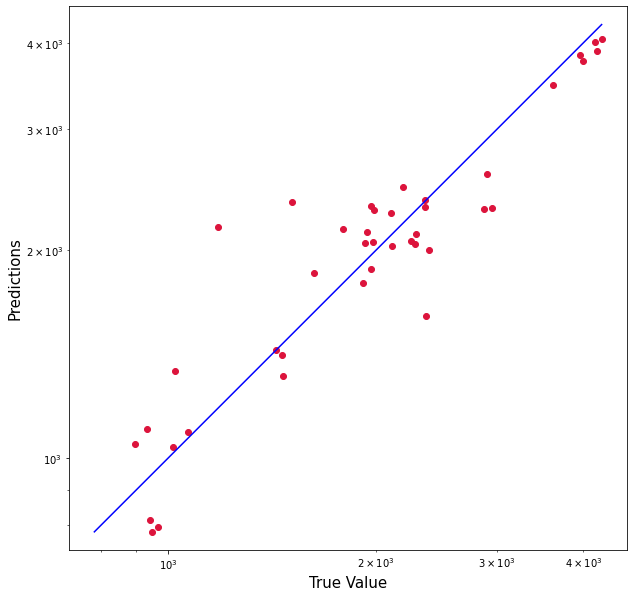

In [126]:
plot_pred_vs_true(list(pred_SVM['Predicted']), list(pred_SVM['ActualValue']))

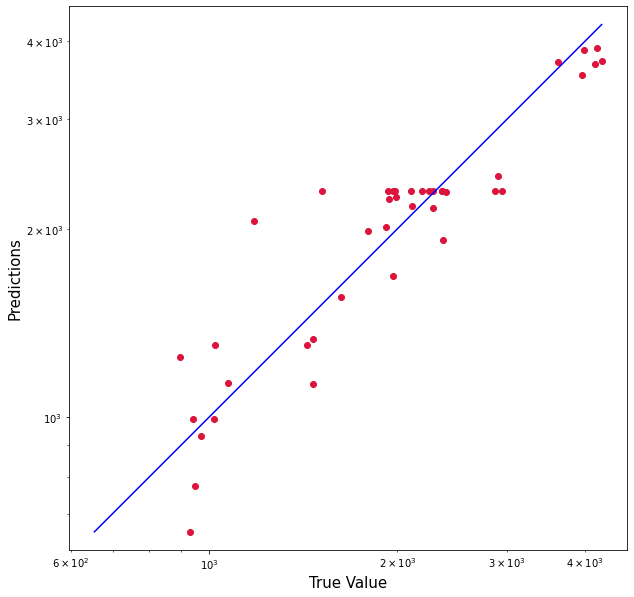

In [127]:
plot_pred_vs_true(list(pred_ANN['Predicted']), list(pred_ANN['ActualValue']))

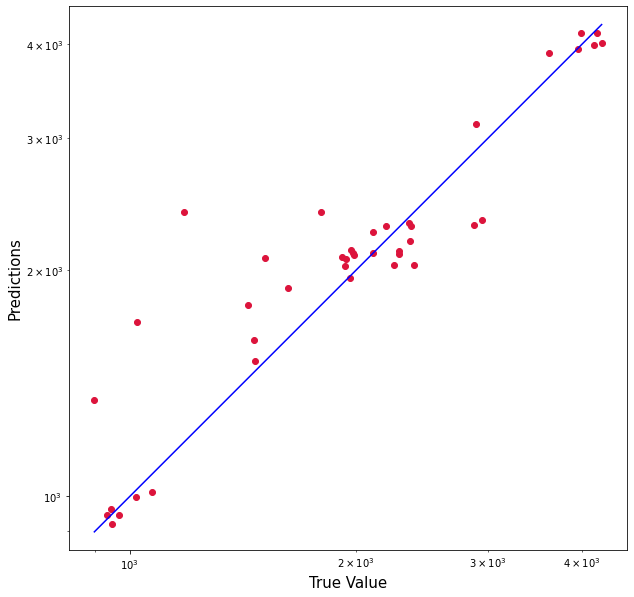

In [129]:
plot_pred_vs_true(list(pred_KNN['Predicted']), list(pred_KNN['ActualValue']))

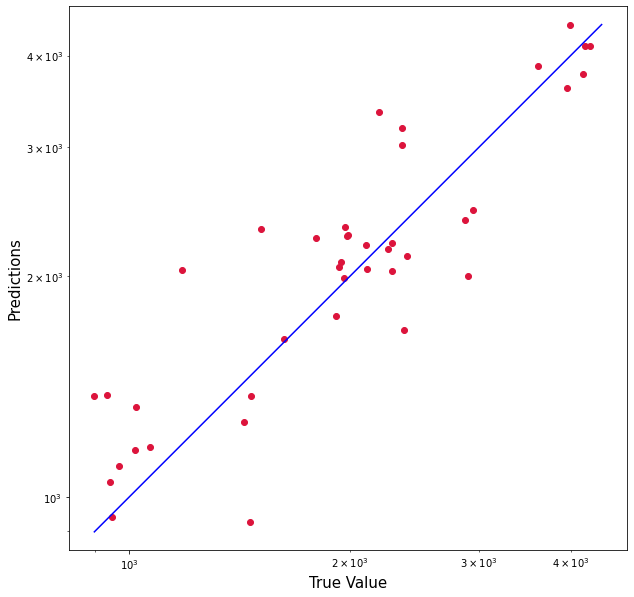

In [133]:
plot_pred_vs_true(list(pred_LR['Predicted']), list(pred_LR['ActualValue']))

targets_ICU_day =pd.read_csv('C:/Users/annac/avr_hosp_data.csv')
icu_filter = targets_ICU_day[['Daily ICU occupancy']].loc[targets_ICU_day['Daily ICU occupancy']>= 0.0]

In [20]:
scores_ANN, pred_ANN = ANN_model(targets_ICU_day,'Daily ICU occupancy', 'avr_Daily_ICU_occupancy')

2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step
  TrialNumber Parameters       MSE  Batch  Epochs
0           1        NaN  0.156295    5.0     5.0
0           2        NaN  0.111236    5.0    10.0
0           3        NaN  0.076921    5.0    50.0
0           4        NaN  0.057389    5.0   100.0
0           5        NaN  0.233990   10.0     5.0
0           6        NaN  0.134526   10.0    10.0
0           7        NaN  0.067426   10.0    50.0
0           8        NaN  0.063124   10.0   100.0
0           9        NaN  0.706901   15.0     5.0
0          10        NaN  0.178513   15.0    10.0
0          11        NaN  0.087641   15.0    50.0
0          12        NaN  0.054543   15.0   100.0
0          13        NaN  0.898965   20.0     5.0
0          14        NaN  0.156924   20.0    10.0
0          15        NaN  0.107767   20.0    50.0
0          16        NaN  0.078090   20.0   100.0
index_m:11
Epoch 1/100


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


11/11 [==============================] - 0s 2ms/step - loss: 0.9621
Epoch 2/100
11/11 [==============================] - 0s 2ms/step - loss: 0.9487
Epoch 3/100
11/11 [==============================] - 0s 2ms/step - loss: 0.9076
Epoch 4/100
11/11 [==============================] - 0s 2ms/step - loss: 0.8300
Epoch 5/100
11/11 [==============================] - 0s 1ms/step - loss: 0.6773
Epoch 6/100
11/11 [==============================] - 0s 1ms/step - loss: 0.4918
Epoch 7/100
11/11 [==============================] - 0s 1ms/step - loss: 0.4124
Epoch 8/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3991
Epoch 9/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3479
Epoch 10/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3437
Epoch 11/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3088
Epoch 12/100
11/11 [==============================] - 0s 2ms/step - loss: 0.3380
Epoch 13/100
11/11 [=============================

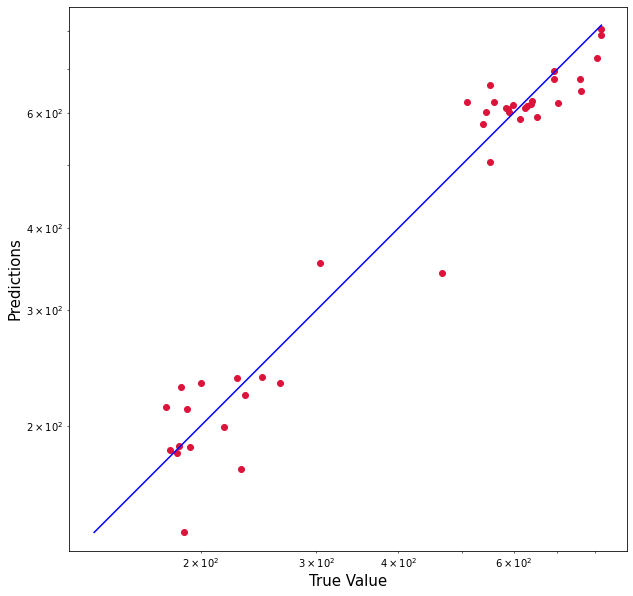

In [24]:
plot_pred_vs_true(list(pred_ANN['Predicted']), list(pred_ANN['ActualValue']))

In [25]:
scores_SVM, pred_SVM = SVM_model(targets_ICU_day,'Daily ICU occupancy', 'avr_Daily_ICU_occupancy')

R-squared: 0.9382067979656566
MSE: 0.06992045826190564


C:\Users\annac\anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [61]:
pred_SVM.head()

,ActualValue,Predicted,Diff
0,5430.333333,4826.704573,603.628760
1,5373.083333,4535.221352,837.861981
2,577.000000,362.540265,214.459735
3,3059.294118,2008.312301,1050.981816
4,913.800000,763.738755,150.061245


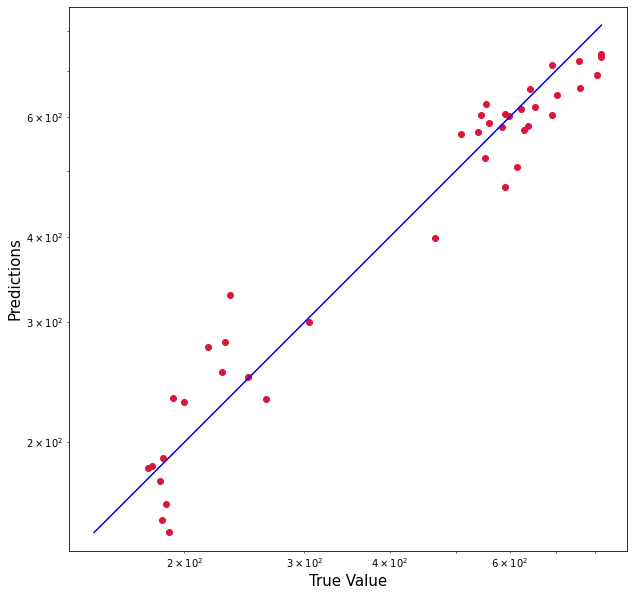

In [26]:
plot_pred_vs_true(list(pred_SVM['Predicted']), list(pred_SVM['ActualValue']))

In [59]:
scores_KNN, pred_KNN = KNN_model(targets_ICU_day,'Daily ICU occupancy', 'avr_Daily_ICU_occupancy')

K=2, val_mse=0.07%
K=3, val_mse=0.05%
K=4, val_mse=0.07%
K=5, val_mse=0.06%
K=6, val_mse=0.07%
K=7, val_mse=0.06%
K=8, val_mse=0.06%
K=9, val_mse=0.07%
K=10, val_mse=0.06%
index_mse:1
R-squared: 0.9528204746601497
MSE: 0.05338474012898881


In [60]:
pred_KNN.head()

,ActualValue,Predicted,Diff
0,804.240000,643.986667,160.253333
1,692.100000,706.403333,14.303333
2,190.125000,184.455000,5.670000
3,757.428571,725.110625,32.317947
4,229.760000,220.675417,9.084583


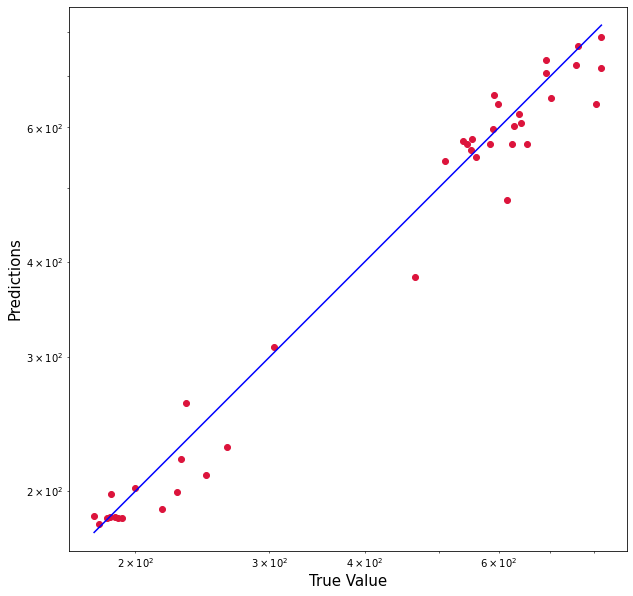

In [28]:
plot_pred_vs_true(list(pred_KNN['Predicted']), list(pred_KNN['ActualValue']))

In [57]:
scores_LR, pred_LR = LR_model(targets_ICU_day,'Daily ICU occupancy', 'avr_Daily_ICU_occupancy')

0.8913930105660517
[-0.03975652]
R-squared: 0.6801342049562251
MSE: 0.3619356536879161


In [58]:
pred_LR.head()

,ActualValue,Predicted,Diff
0,804.240000,759.168122,45.071878
1,692.100000,665.850791,26.249209
2,190.125000,101.078080,89.046920
3,757.428571,794.872144,37.443572
4,229.760000,-245.413225,475.173225


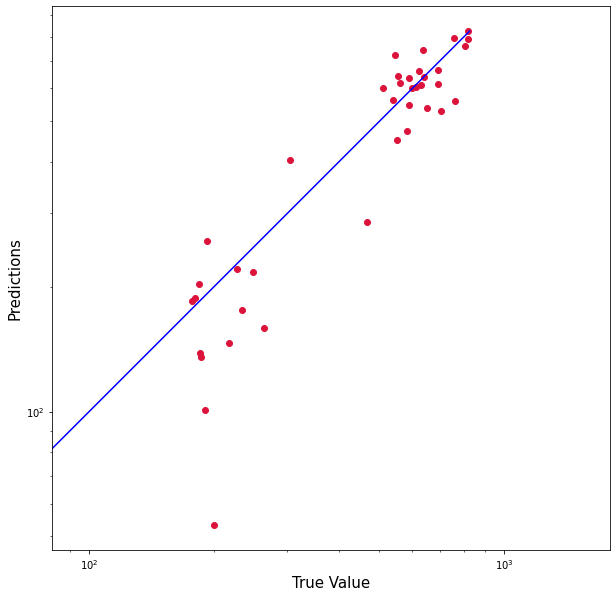

In [30]:
plot_pred_vs_true(list(pred_LR['Predicted']), list(pred_LR['ActualValue']))

In [31]:
targets_ICU_week =pd.read_csv('C:/Users/annac/avr_hosp_data.csv')
icu_filter = targets_ICU_week[['Weekly new ICU admissions']].loc[targets_ICU_week['Weekly new ICU admissions']>= 0.0]

In [32]:
scores_ANN, pred_ANN = ANN_model(icu_filter,'Weekly new ICU admissions', 'avr_weekly_ICU_admissions')

2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step
  TrialNumber Parameters       MSE  Batch  Epochs
0           1        NaN  0.435306    5.0     5.0
0           2        NaN  0.334146    5.0    10.0
0           3        NaN  0.282218    5.0    50.0
0           4        NaN  0.289707    5.0   100.0
0           5        NaN  0.530667   10.0     5.0
0           6        NaN  0.405478   10.0    10.0
0           7        NaN  0.352167   10.0    50.0
0           8        NaN  0.252626   10.0   100.0
0           9        NaN  0.863609   15.0     5.0
0          10        NaN  0.377346   15.0    10.0
0          11        NaN  0.459369   15.0    50.0
0          12        NaN  0.333323   15.0   100.0
0          13        NaN  1.082930   20.0     5.0
0          14        NaN  0.418582   20.0    10.0
0          15        NaN  0.368330   20.0    50.0
0          16        NaN  0.326142   20.0   100.0
index_m:7
Epoch 1/100


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


17/17 [==============================] - 0s 2ms/step - loss: 0.9324
Epoch 2/100
17/17 [==============================] - 0s 2ms/step - loss: 0.9207
Epoch 3/100
17/17 [==============================] - 0s 2ms/step - loss: 0.8766
Epoch 4/100
17/17 [==============================] - 0s 1ms/step - loss: 0.7888
Epoch 5/100
17/17 [==============================] - 0s 2ms/step - loss: 0.6973
Epoch 6/100
17/17 [==============================] - 0s 2ms/step - loss: 0.5182
Epoch 7/100
17/17 [==============================] - 0s 2ms/step - loss: 0.4881
Epoch 8/100
17/17 [==============================] - 0s 2ms/step - loss: 0.4756
Epoch 9/100
17/17 [==============================] - 0s 2ms/step - loss: 0.4422
Epoch 10/100
17/17 [==============================] - 0s 2ms/step - loss: 0.5258
Epoch 11/100
17/17 [==============================] - 0s 1ms/step - loss: 0.5317
Epoch 12/100
17/17 [==============================] - 0s 2ms/step - loss: 0.3404
Epoch 13/100
17/17 [=============================

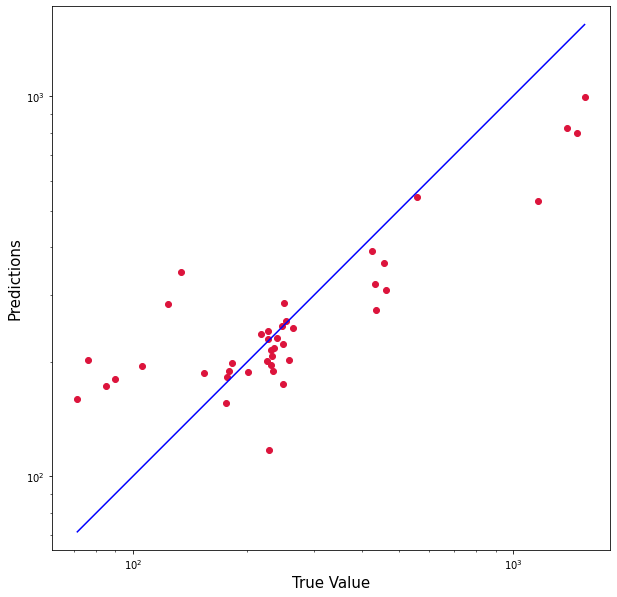

In [33]:
plot_pred_vs_true(list(pred_ANN['Predicted']), list(pred_ANN['ActualValue']))

In [37]:
scores_SVM, pred_SVM = SVM_model(icu_filter,'Weekly new ICU admissions', 'avr_weekly_ICU_admissions')

R-squared: 0.7040290611204156
MSE: 0.3707295213229099


C:\Users\annac\anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


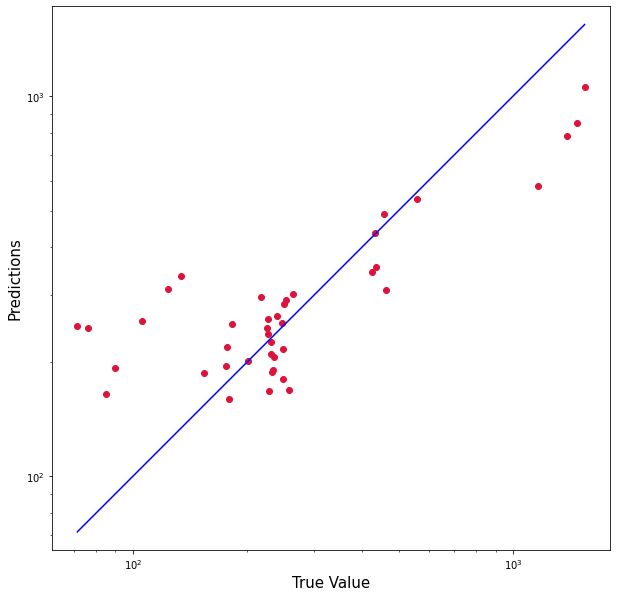

In [35]:
plot_pred_vs_true(list(pred_SVM['Predicted']), list(pred_SVM['ActualValue']))

In [36]:
scores_KNN, pred_KNN = KNN_model(icu_filter,'Weekly new ICU admissions', 'avr_weekly_ICU_admissions')

K=2, val_mse=0.40%
K=3, val_mse=0.42%
K=4, val_mse=0.45%
K=5, val_mse=0.37%
K=6, val_mse=0.42%
K=7, val_mse=0.43%
K=8, val_mse=0.47%
K=9, val_mse=0.50%
K=10, val_mse=0.53%
index_mse:3
R-squared: 0.7042327330368956
MSE: 0.3704744044104543


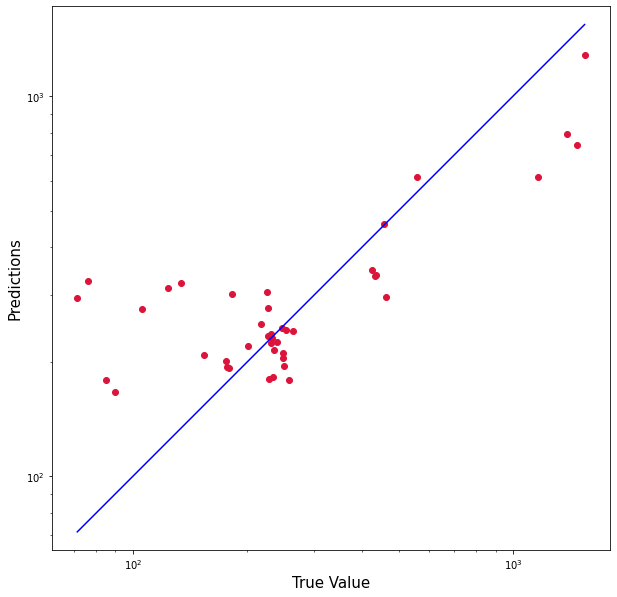

In [38]:
plot_pred_vs_true(list(pred_KNN['Predicted']), list(pred_KNN['ActualValue']))

In [39]:
scores_LR, pred_LR = LR_model(icu_filter,'Weekly new ICU admissions', 'avr_weekly_ICU_admissions')

0.8667863054921379
[-0.00144471]
R-squared: 0.8225700389052232
MSE: 0.2222465651324339


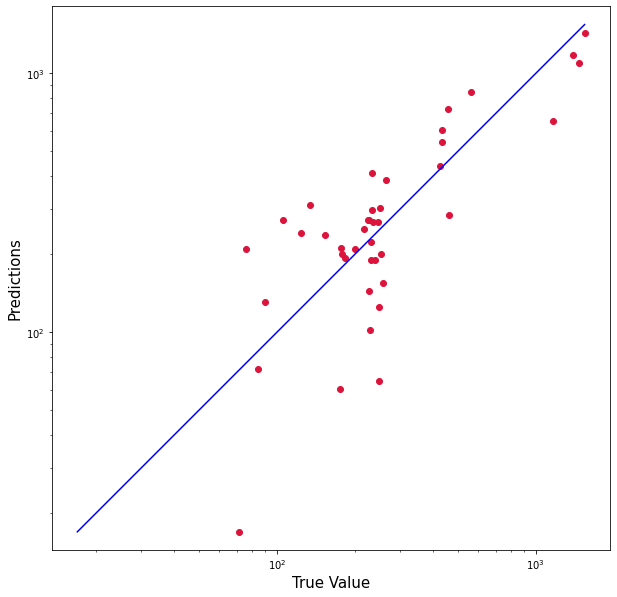

In [40]:
plot_pred_vs_true(list(pred_LR['Predicted']), list(pred_LR['ActualValue']))

In [41]:
targets_hosp_week =pd.read_csv('C:/Users/annac/avr_hosp_data.csv')
hosp_filter = targets_hosp_week[['Weekly new hospital admissions']].loc[targets_hosp_week['Weekly new hospital admissions']>= 0.0]

In [43]:
scores_ANN, pred_ANN = ANN_model(hosp_filter,'Weekly new hospital admissions', 'avr_weekly_hosp_admissions')

2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 3ms/step


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


2/2 [==============================] - 0s 2ms/step
  TrialNumber Parameters       MSE  Batch  Epochs
0           1        NaN  0.301975    5.0     5.0
0           2        NaN  0.277401    5.0    10.0
0           3        NaN  0.158200    5.0    50.0
0           4        NaN  0.164317    5.0   100.0
0           5        NaN  0.487980   10.0     5.0
0           6        NaN  0.293060   10.0    10.0
0           7        NaN  0.173388   10.0    50.0
0           8        NaN  0.174582   10.0   100.0
0           9        NaN  0.705128   15.0     5.0
0          10        NaN  0.334079   15.0    10.0
0          11        NaN  0.196708   15.0    50.0
0          12        NaN  0.193183   15.0   100.0
0          13        NaN  0.953179   20.0     5.0
0          14        NaN  0.284347   20.0    10.0
0          15        NaN  0.186005   20.0    50.0
0          16        NaN  0.185024   20.0   100.0
index_m:2
Epoch 1/50


C:\Users\annac\AppData\Local\Temp/ipykernel_3592/695762972.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, MSE]],


33/33 [==============================] - 0s 1ms/step - loss: 0.9542
Epoch 2/50
33/33 [==============================] - 0s 1ms/step - loss: 0.8372
Epoch 3/50
33/33 [==============================] - 0s 1ms/step - loss: 0.5449
Epoch 4/50
33/33 [==============================] - 0s 1ms/step - loss: 0.4528
Epoch 5/50
33/33 [==============================] - 0s 1ms/step - loss: 0.4231
Epoch 6/50
33/33 [==============================] - 0s 2ms/step - loss: 0.3814
Epoch 7/50
33/33 [==============================] - 0s 2ms/step - loss: 0.3511
Epoch 8/50
33/33 [==============================] - 0s 1ms/step - loss: 0.3499
Epoch 9/50
33/33 [==============================] - 0s 1ms/step - loss: 0.3049
Epoch 10/50
33/33 [==============================] - 0s 1ms/step - loss: 0.2907
Epoch 11/50
33/33 [==============================] - 0s 2ms/step - loss: 0.2826
Epoch 12/50
33/33 [==============================] - 0s 2ms/step - loss: 0.3046
Epoch 13/50
33/33 [==============================] - 0s 2ms/

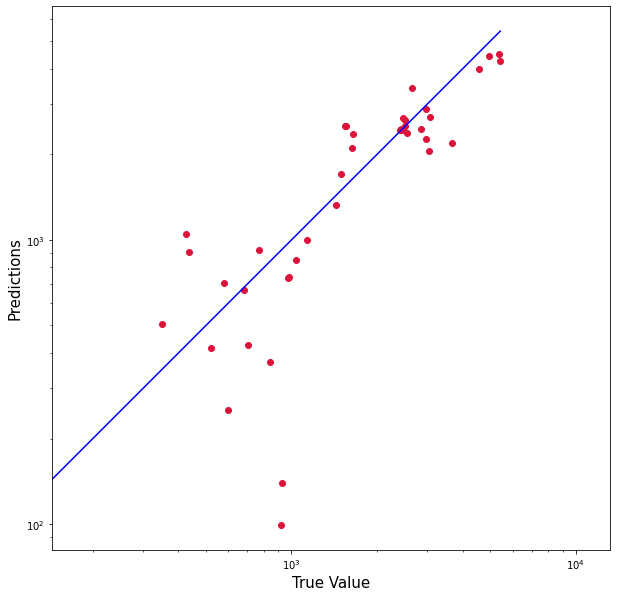

In [44]:
plot_pred_vs_true(list(pred_ANN['Predicted']), list(pred_ANN['ActualValue']))

In [45]:
scores_SVM, pred_SVM = SVM_model(hosp_filter,'Weekly new hospital admissions', 'avr_weekly_hosp_admissions')

R-squared: 0.8654805408603721
MSE: 0.15432095638176144


C:\Users\annac\anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [55]:
pred_SVM.head()

,ActualValue,Predicted,Diff
0,5430.333333,4826.704573,603.628760
1,5373.083333,4535.221352,837.861981
2,577.000000,362.540265,214.459735
3,3059.294118,2008.312301,1050.981816
4,913.800000,763.738755,150.061245


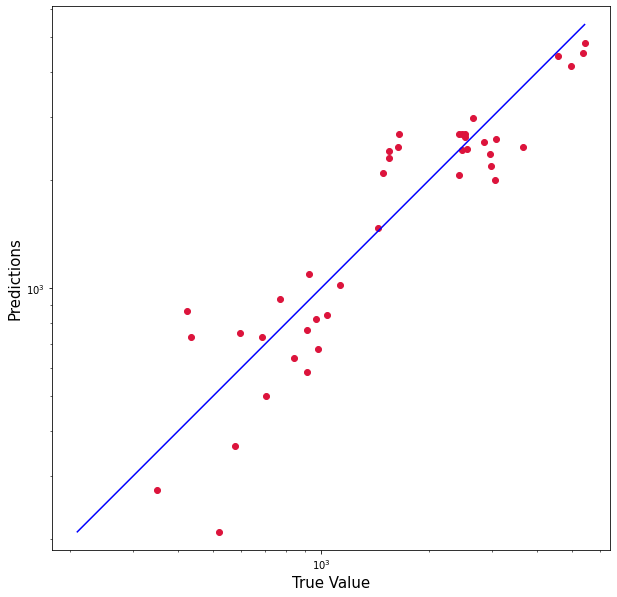

In [48]:
plot_pred_vs_true(list(pred_SVM['Predicted']), list(pred_SVM['ActualValue']))

In [49]:
scores_KNN, pred_KNN = KNN_model(hosp_filter,'Weekly new hospital admissions', 'avr_weekly_hosp_admissions')

K=2, val_mse=0.13%
K=3, val_mse=0.11%
K=4, val_mse=0.12%
K=5, val_mse=0.11%
K=6, val_mse=0.11%
K=7, val_mse=0.12%
K=8, val_mse=0.13%
K=9, val_mse=0.14%
K=10, val_mse=0.15%
index_mse:3
R-squared: 0.9052264599260736
MSE: 0.1087243692283401


In [54]:
pred_KNN.head()

,ActualValue,Predicted,Diff
0,5430.333333,5001.467576,428.865758
1,5373.083333,5001.467576,371.615758
2,577.000000,510.874286,66.125714
3,3059.294118,2287.644796,771.649321
4,913.800000,846.946667,66.853333


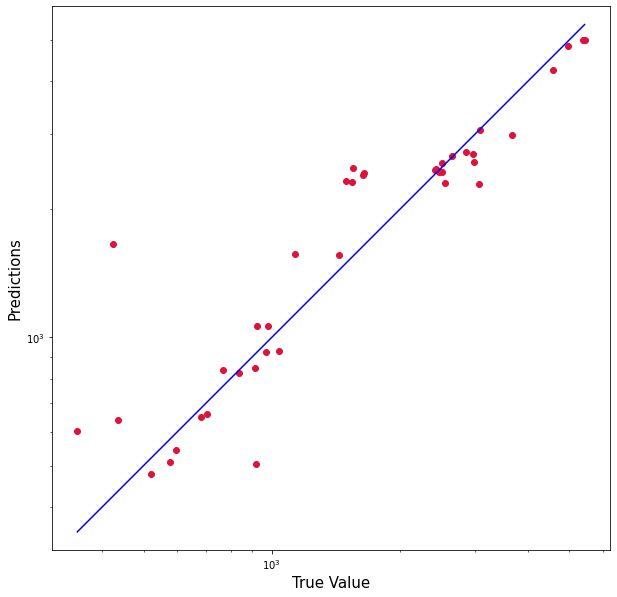

In [50]:
plot_pred_vs_true(list(pred_KNN['Predicted']), list(pred_KNN['ActualValue']))

In [47]:
scores_LR, pred_LR = LR_model(hosp_filter,'Weekly new hospital admissions', 'avr_weekly_hosp_admissions')

0.909132164511277
[0.00041717]
R-squared: 0.7893593281376068
MSE: 0.24164734338517227


In [53]:
pred_LR.head()

,ActualValue,Predicted,Diff
0,5430.333333,4459.335710,970.997624
1,5373.083333,5412.574911,39.491577
2,577.000000,-378.372304,955.372304
3,3059.294118,2510.044546,549.249572
4,913.800000,501.454848,412.345152


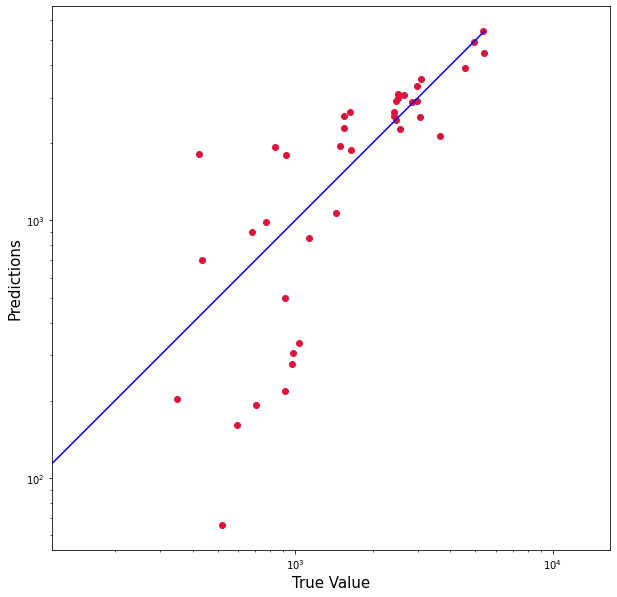

In [51]:
plot_pred_vs_true(list(pred_LR['Predicted']), list(pred_LR['ActualValue']))